In [1]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

df = pd.read_csv (r'train.csv')
print (df)

        image_name                                           tags
0          train_0                                   haze primary
1          train_1                agriculture clear primary water
2          train_2                                  clear primary
3          train_3                                  clear primary
4          train_4      agriculture clear habitation primary road
...            ...                                            ...
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary

[40479 rows x 2 columns]


In [2]:
tagdictionary={}
columns=(df.tags.tolist())

In [3]:
for i in columns:
    words=i.split()
    for j in words:
        if j in tagdictionary.keys():
            tagdictionary[j]=tagdictionary[j]+1
        else:
            tagdictionary[j]=1
dactictionarysorted=sorted(tagdictionary.items(),key=lambda x:x[1])
print(dactictionarysorted)

[('conventional_mine', 100), ('blow_down', 101), ('slash_burn', 209), ('blooming', 332), ('artisinal_mine', 339), ('selective_logging', 340), ('bare_ground', 862), ('cloudy', 2089), ('haze', 2697), ('habitation', 3660), ('cultivation', 4547), ('partly_cloudy', 7261), ('water', 7411), ('road', 8071), ('agriculture', 12315), ('clear', 28431), ('primary', 37513)]


In [4]:
taglist=list(tagdictionary.keys())
print(taglist)

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [5]:
def encodingbinaryArray(taglist,tags):
    encoding=np.zeros(len(taglist),dtype='uint8')
    #print(type(encoding))
    for tag in tags:
        index=taglist.index(tag)
        encoding[index]=1
    return encoding
print(encodingbinaryArray(taglist,["clear","cloudy"]))



[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [6]:
def filePrepare(df):
    imgnames=df.image_name.tolist()
    tags=[]
    for s in df.tags.tolist():
        tags.append(s.split(" "))
    return [imgnames,tags]
result=filePrepare(df)
print(result[0][0:20])
print(result[1][0:20])

['train_0', 'train_1', 'train_2', 'train_3', 'train_4', 'train_5', 'train_6', 'train_7', 'train_8', 'train_9', 'train_10', 'train_11', 'train_12', 'train_13', 'train_14', 'train_15', 'train_16', 'train_17', 'train_18', 'train_19']
[['haze', 'primary'], ['agriculture', 'clear', 'primary', 'water'], ['clear', 'primary'], ['clear', 'primary'], ['agriculture', 'clear', 'habitation', 'primary', 'road'], ['haze', 'primary', 'water'], ['agriculture', 'clear', 'cultivation', 'primary', 'water'], ['haze', 'primary'], ['agriculture', 'clear', 'cultivation', 'primary'], ['agriculture', 'clear', 'cultivation', 'primary', 'road'], ['agriculture', 'clear', 'primary', 'slash_burn', 'water'], ['clear', 'primary', 'water'], ['cloudy'], ['clear', 'primary'], ['cloudy'], ['clear', 'primary'], ['clear', 'primary'], ['partly_cloudy', 'primary'], ['clear', 'primary'], ['agriculture', 'clear', 'primary', 'road']]


In [7]:
def encodingBinaryPrepare(tags):
    encodedlist=[]
    for i in tags:
        encodedlist.append(encodingbinaryArray(taglist,i))
                        
    return encodedlist


file_names=result[0]
file_tags=encodingBinaryPrepare(result[1]) 
#print(file_names)
#print(file_tags)
    

In [8]:
def prepare_X_y(path,file_names,file_tags):
    photos,codes=list(),list()
    i=0
    for file_name in file_names:
        #dirname = os.path.dirname(__file__)
        realfilename = 'train-jpg/'+file_name+'.jpg'
        photo=load_img(realfilename,target_size=(128,128))
        photo=img_to_array(photo,dtype="uint8")
        photos.append(photo)
        codes.append(file_tags[i])
        i=i+1
    
    X=np.asarray(photos,dtype='uint8')
    y=np.asarray(codes,dtype='uint8')
    return X,y
X,y=prepare_X_y("path",file_names,file_tags)
print(X.shape)
print(y.shape)

(40479, 128, 128, 3)
(40479, 17)


In [9]:
np.savez_compressed('Loaded_Images_Tags.npz',X,y)

In [1]:
from sklearn.model_selection import train_test_split
from keras import backend

def divide_train_test():
    data=np.load('Loaded_Images_Tags.npz')
    X,y=data['arr_0'],data['arr_1']
    
    trainX,testX,trainY,testY=train_test_split(X,y,test_size=0.3,random_state=1)
    print(trainX.shape,testX.shape,trainY.shape,testY.shape)
    return trainX,testX,trainY,testY

#trainX,testX,trainY,testY=divide_train_test()

 

In [2]:
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD

In [3]:
def fbeta(y_true, y_pred, beta=2):
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    p = tp / (tp + fp + backend.epsilon())
    r = tp / (tp + fn + backend.epsilon())
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [4]:
def define_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [5]:
def ploting_graphs(history):
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
    pyplot.tight_layout()
    

In [6]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="high_accuracy.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

In [ ]:
trainX, testX, trainY, testY = divide_train_test()

train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = train_datagen.flow(trainX, trainY, batch_size=32)
test_it = test_datagen.flow(testX, testY, batch_size=32)

def stage(i):
    if(i==0):
        model = define_model()
        model.summary()
    else:
        model=load_model("Epochs/"+str(i-1)+'_Model',custom_objects={'fbeta':fbeta},compile=False)
        opt = SGD(lr=0.01, momentum=0.9)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
        
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=5, verbose=1) #epochs=50
    loss, fbeta_ = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta_))
    ploting_graphs(history)
    model.save("Epochs/"+str(i)+'_Model',save_format='tf')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

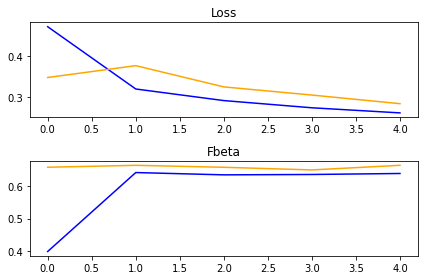

In [17]:
stage(0)

Epoch 1/5
6/6 [==============================] - 52s 8s/step - loss: 0.2574 - fbeta: 0.6288 - val_loss: 0.2705 - val_fbeta: 0.6412
Epoch 2/5
6/6 [==============================] - 50s 8s/step - loss: 0.2479 - fbeta: 0.6425 - val_loss: 0.2855 - val_fbeta: 0.6777
Epoch 3/5
6/6 [==============================] - 75s 13s/step - loss: 0.2500 - fbeta: 0.6302 - val_loss: 0.2657 - val_fbeta: 0.6610
Epoch 4/5
6/6 [==============================] - 78s 13s/step - loss: 0.2500 - fbeta: 0.6391 - val_loss: 0.2526 - val_fbeta: 0.6571
Epoch 5/5
3/3 [==============================] - 7s 2s/step - loss: 0.2606 - fbeta: 0.6437
> loss=0.261, fbeta=0.644
INFO:tensorflow:Assets written to: Epochs/1_Model\assets


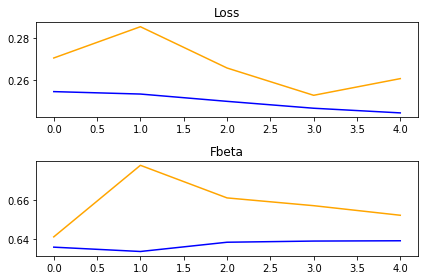

In [18]:
stage(1)